# Event related potentials

In [1]:
%matplotlib inline

In [2]:
import os
import os.path as op
import itertools

import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns
import pingouin

from utils import (
    get_erps_by_dict,
    BIDS_ROOT,
    dict2arr,
    arr2df,
    split_key_col,
    split_dict,
)

In [3]:
# IO: Where to find the data
# Where to find epochs
fname_epo_template = op.join(
    BIDS_ROOT, "derivatives", "sub-{0:02}", "sub-{0:02}_epochs-epo.fif.gz"
)


# Pack all names in a dict
name_templates = dict()
name_templates["epochs"] = fname_epo_template

subjects = range(1, 41)

In [4]:
# save data for publication plots
plotdir = op.join(BIDS_ROOT, "code", "publication_plots")
os.makedirs(plotdir, exist_ok=True)

In [5]:
def plot_topos(
    erp_dict, vminmax, tmin=-0.1, tmax=0.8, step=0.1, extrapolate="head", sphere=None
):
    """Plot a topography over time."""
    # Figure settings
    times = np.arange(tmin, tmax, step)

    # Set up figure
    n_keys = len(erp_dict)
    fig, axs = plt.subplots(n_keys, len(times) + 1, figsize=(15, 2 * n_keys))
    axs = np.atleast_2d(axs)

    for ii, key in enumerate(erp_dict):
        # Drop NaNs
        arr = np.asarray(erp_dict[key])
        n_nans = pd.isnull(arr).sum()
        if n_nans > 0:
            print("dropping {} nans from {} before plotting".format(n_nans, key))
            arr = arr[pd.notnull(arr)]

        # plot colorbar only on first iteration
        colorbar = True  # if ii == 0 else False

        with mne.utils.use_log_level(0):
            # Form grand average
            ga = mne.grand_average(list(arr))

            # plot
            mne.viz.plot_evoked_topomap(
                ga,
                times=times,
                vmin=-vminmax,
                vmax=vminmax,
                axes=axs[ii, :],
                colorbar=colorbar,
                extrapolate=extrapolate,
                sphere=sphere,
            )
        axs[ii, 0].set_ylabel(key)

    fig.suptitle("Sample ERP")

    return fig, axs

In [6]:
def plot_single_erp(
    erp_dict,
    chn_grp,
    title,
    colors=None,
    linestyles=None,
    ylim=None,
    cmap=None,
    ax=None,
    special_legend=False,
):
    """Plot a single panel ERP."""
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()

    if colors is None:
        legend = False
    elif special_legend:
        legend = False
    else:
        legend = True

    # Drop NaNs
    for key in erp_dict:
        arr = np.asarray(erp_dict[key])
        n_nans = pd.isnull(arr).sum()
        if n_nans > 0:
            print("dropping {} nans from {} before plotting".format(n_nans, key))
            arr = arr[pd.notnull(arr)]
            erp_dict[key] = list(arr)

    # plot
    with mne.utils.use_log_level(0):
        mne.viz.plot_compare_evokeds(
            erp_dict,
            ylim=ylim,
            picks=chn_grp,
            combine="mean",
            axes=ax,
            show_sensors="lower left",
            legend=legend,
            ci=0.68,
            truncate_xaxis=False,
            truncate_yaxis=False,
            title=title,
            colors=colors,
            linestyles=linestyles,
            cmap=cmap,
        )

    if special_legend:
        # make ordering: stopping*sampling
        ordering = zip(
            ["variable", "variable", "fixed", "fixed"],
            ["active", "yoked", "active", "yoked"],
        )
        legend_elements = []
        for stopping, sampling in ordering:
            legend_elements.append(
                Line2D(
                    [0],
                    [0],
                    color=colors[stopping],
                    linestyle=linestyles[sampling],
                    label=f"{sampling}/{stopping}",
                )
            )

        ax.legend(
            handles=legend_elements,
            loc="best",
            prop={"size": 13},
            framealpha=1,
        )

    return fig, ax

# Define analysis parameters

In [7]:
# preprocessing settings
preproc_settings = {
    "crop": (0.6, 1.6),
    "tshift": -0.8,
    "smooth": False,
    "baseline": (None, 0),
}

In [8]:
# Electrode groups for summarizing across channels
p3_grp = ["Cz", "C1", "C2", "CPz", "CP1", "CP2", "CP3", "CP4", "Pz", "P1", "P2"]

p1_n1_grp = ["O2", "PO4", "PO8", "PO10"]

In [9]:
# Time windows for ERP components
p3_window = (0.3, 0.6)

In [10]:
# define single panel plot scaling
single_panel_ylim = dict(eeg=[-2, 2])

In [11]:
# Define factors
sampling_styles = ("active", "yoked")
stopping_styles = ("fixed", "variable")
timings = ("early", "mid", "late")

In [12]:
# Get an ERP for extracting channel names and times array
# it's the same for all ERPs and will be used below
tmp = get_erps_by_dict({"all": list()}, name_templates, [1], **preproc_settings)
ch_names = tmp["all"][0].ch_names
times = tmp["all"][0].times

# Sample ERP left - right contrast

## double subtraction

In [13]:
# Make SIDED overall_erps = soverall_erps: DOUBLE SUBTRACTION
# i.e., left - right, see "subtract" param for get_erps_by_dict
# double_subtraction=True !
try:
    ssoverall_erps
    print("Data already loaded")
except NameError:
    subtract = ("left", "right")

    ssoverall_erps = {
        "{0}/{1}".format(*ii): list()
        for ii in itertools.product(sampling_styles, stopping_styles)
    }
    ssoverall_erps = get_erps_by_dict(
        ssoverall_erps,
        name_templates,
        subjects,
        subtract=subtract,
        double_subtraction=True,
        **preproc_settings
    )

In [14]:
p1_window = (0.08, 0.13)
n1_window = (0.14, 0.20)

<ipython-input-6-bd89d5f2150c>:50: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  cmap=cmap,
<ipython-input-6-bd89d5f2150c>:50: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  cmap=cmap,


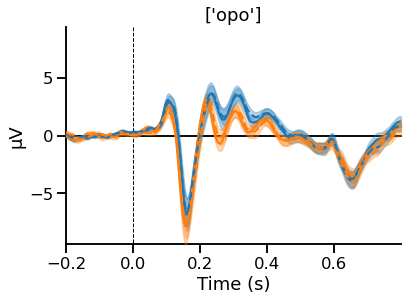

In [15]:
with sns.plotting_context(context="talk", font_scale=1):

    colors = {"variable": sns.color_palette()[1], "fixed": sns.color_palette()[0]}
    linestyles = {"active": "-", "yoked": "--"}
    custom_grp = ["opo"]
    fig, ax = plot_single_erp(
        ssoverall_erps,
        custom_grp,
        "{}".format(custom_grp),
        colors,
        linestyles,
        ylim=None,
        special_legend=True,
    )

    # P1 window
    p1_window = (0.08, 0.13)
    ax.axvspan(*p1_window, color="black", alpha=0.1)

    # N1 from 140ms to 200ms
    n1_window = (0.14, 0.20)
    ax.axvspan(*n1_window, color="black", alpha=0.1)

    # improve legend
    leg = ax.get_legend()
    leg.get_texts()[0].set_text("Full control")
    leg.get_texts()[1].set_text("Yoked")
    leg.get_texts()[2].set_text("Partial control")
    leg.get_texts()[3].set_text("Yoked")


### Stats

In [16]:
special_group = ["opo"]
special_ch_names = ssoverall_erps["active/fixed"][0].ch_names

In [17]:
ssoverall_arr = dict2arr(ssoverall_erps)

sp1_df = arr2df(
    ssoverall_arr,
    special_group,
    p1_window,
    ssoverall_erps.keys(),
    special_ch_names,
    times,
)

sn1_df = arr2df(
    ssoverall_arr,
    special_group,
    n1_window,
    ssoverall_erps.keys(),
    special_ch_names,
    times,
)


sp1_df = split_key_col(sp1_df, ["sampling", "stopping"])
sn1_df = split_key_col(sn1_df, ["sampling", "stopping"])


# Get "subject" column from "subj_repr" by making use of knowledge of which
# subj was in which stopping condition
tmp = pd.read_csv(op.join(BIDS_ROOT, "participants.tsv"), sep="\t")
fixed_ids = sorted([int(i[-2:]) for i in tmp[tmp["stopping"] == "fixed"]["participant_id"]])
variable_ids = sorted([int(i[-2:]) for i in tmp[tmp["stopping"] == "variable"]["participant_id"]])

sp1_df["subject"] = pd.concat(
    [
        sp1_df[sp1_df["stopping"] == "fixed"]["subj_repr"].map(
            dict(zip(range(20), fixed_ids))
        ),
        sp1_df[sp1_df["stopping"] == "variable"]["subj_repr"].map(
            dict(zip(range(20), variable_ids))
        ),
    ]
)


sn1_df["subject"] = pd.concat(
    [
        sn1_df[sn1_df["stopping"] == "fixed"]["subj_repr"].map(
            dict(zip(range(20), fixed_ids))
        ),
        sn1_df[sn1_df["stopping"] == "variable"]["subj_repr"].map(
            dict(zip(range(20), variable_ids))
        ),
    ]
)

# reorder cols
sp1_df = sp1_df[['key', 'sampling', 'stopping', 'subject', 'subj_repr', 'mean_amp']]
sn1_df = sn1_df[['key', 'sampling', 'stopping', 'subject', 'subj_repr', 'mean_amp']]


sp1_df["sampling"] = sp1_df["sampling"].str.capitalize()
sp1_df["stopping"] = sp1_df["stopping"].str.capitalize()
sn1_df["sampling"] = sn1_df["sampling"].str.capitalize()
sn1_df["stopping"] = sn1_df["stopping"].str.capitalize()

In [18]:
groups = {"p1": special_group, "n1": special_group}
windows = {"p1": p1_window, "n1": n1_window}
erps = {"p1": sp1_df, "n1": sn1_df}

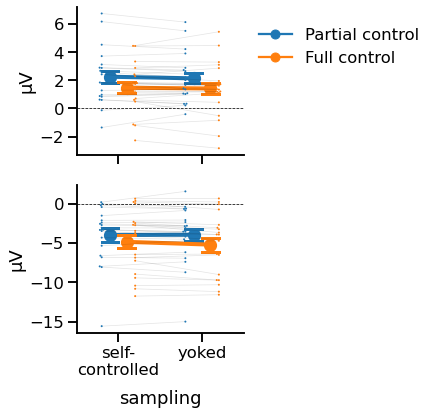

In [19]:
scale = 1
errwidth = 3
capsize = 0.2

labelpad = 12

swarmsize = 2

with sns.plotting_context("talk", font_scale=1):
    fig, axs = plt.subplots(
        2, 1, figsize=(3, 6), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
    )

for ii, use in enumerate(("p1", "n1")):
    group = groups[use]
    window = windows[use]
    tmp = erps[use]

    with sns.plotting_context("talk", font_scale=1):
        ax = axs[ii]

        sns.pointplot(
            x="sampling",
            y="mean_amp",
            hue="stopping",
            data=tmp,
            dodge=0.2,
            ci=68,
            hue_order=["Fixed", "Variable"],
            ax=ax,
            markers="o",
            scale=scale,
            errwidth=errwidth,
            capsize=capsize,
        )

        sns.swarmplot(
            x="sampling",
            y="mean_amp",
            hue="stopping",
            data=tmp,
            hue_order=["Fixed", "Variable"],
            ax=ax,
            dodge=True,
            size=swarmsize,
        )

        # add legend
        # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        legend_elements = [
            Line2D([0], [0], color=sns.color_palette()[0], marker="o", label="Fixed"),
            Line2D(
                [0], [0], color=sns.color_palette()[1], marker="o", label="Variable"
            ),
        ]

        ax.legend(
            handles=legend_elements,
            loc="lower left",
            frameon=False,
            bbox_to_anchor=(1, 0.5),
        )

        ax.set_ylabel("Mean amplitude")

        # https://stackoverflow.com/a/51157346/5201771
        # 2-4 3-5
        for idx0, idx1 in [(2, 4), (3, 5)]:
            locs1 = ax.get_children()[idx0].get_offsets()
            locs2 = ax.get_children()[idx1].get_offsets()

            for i in range(locs1.shape[0]):
                x = [locs1[i, 0], locs2[i, 0]]
                y = [locs1[i, 1], locs2[i, 1]]
                ax.plot(x, y, color="black", alpha=0.1, linewidth=0.75)

        ax.axhline(0, color="black", linewidth=0.75, linestyle="--")
        ax.set_title(
            f"{use}\nMean amplitudes {' - '.join(subtract)}\nwindow_seconds: {window}, channels: {group}"
        )

        # settings
        ax.set_title("")
        ax.set_ylabel("µV")
        if ii == 0:
            ax.set_xlabel("")
            leg = ax.get_legend()
            leg.get_texts()[0].set_text("Partial control")
            leg.get_texts()[1].set_text("Full control")
        else:
            ax.get_legend().remove()

        ax.set_xticklabels(["self-\ncontrolled", "yoked"])
        ax.set_xlabel(ax.get_xlabel(), labelpad=labelpad)

sns.despine(fig)

In [20]:
# analyze in mixed model
for use in ("p1", "n1"):
    tmp = erps[use]
    stats = pingouin.mixed_anova(
        data=tmp,
        dv="mean_amp",
        within="sampling",
        subject="subject",
        between="stopping",
    )
    print(use)
    display(stats.round(3))

p1


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,stopping,11.269,1,38,11.269,1.704,0.200,0.043,NaN
1,sampling,0.138,1,38,0.138,0.495,0.486,0.013,1.0
2,Interaction,0.020,1,38,0.020,0.070,0.792,0.002,NaN


n1


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,stopping,22.687,1,38,22.687,0.795,0.378,0.020,NaN
1,sampling,0.501,1,38,0.501,0.844,0.364,0.022,1.0
2,Interaction,0.754,1,38,0.754,1.270,0.267,0.032,NaN


# Sample ERPs early/mid/late AF/AV/YF/YV SPLIT

In [21]:
condi_early_mid_late_erps = {
    "{}/{}/{}".format(*ii): list()
    for ii in itertools.product(sampling_styles, stopping_styles, timings)
}
condi_early_mid_late_erps = get_erps_by_dict(
    condi_early_mid_late_erps, name_templates, subjects, **preproc_settings
)

In [22]:
# also convert to array
condi_early_mid_late_arr = dict2arr(condi_early_mid_late_erps)

In [23]:
split_condi_early_mid_late_erps = split_dict(condi_early_mid_late_erps)

## Topo

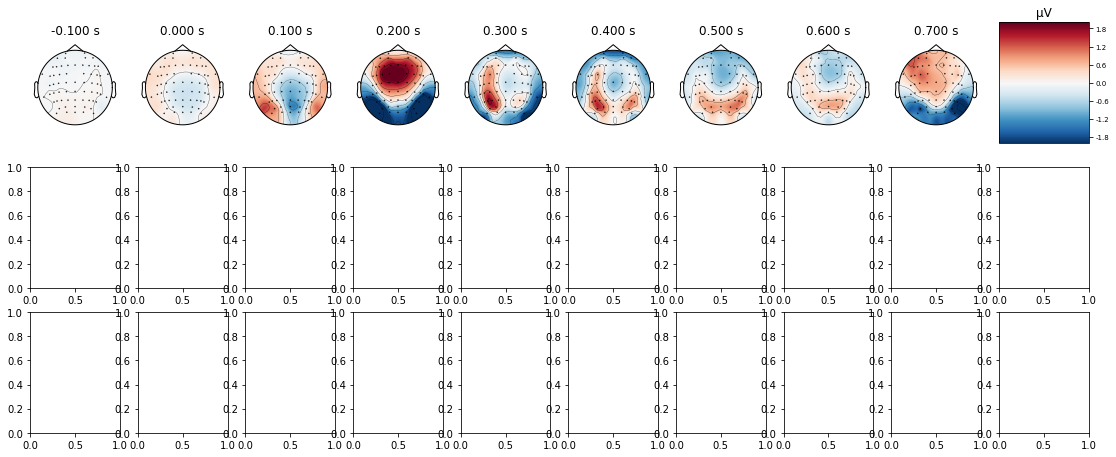

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

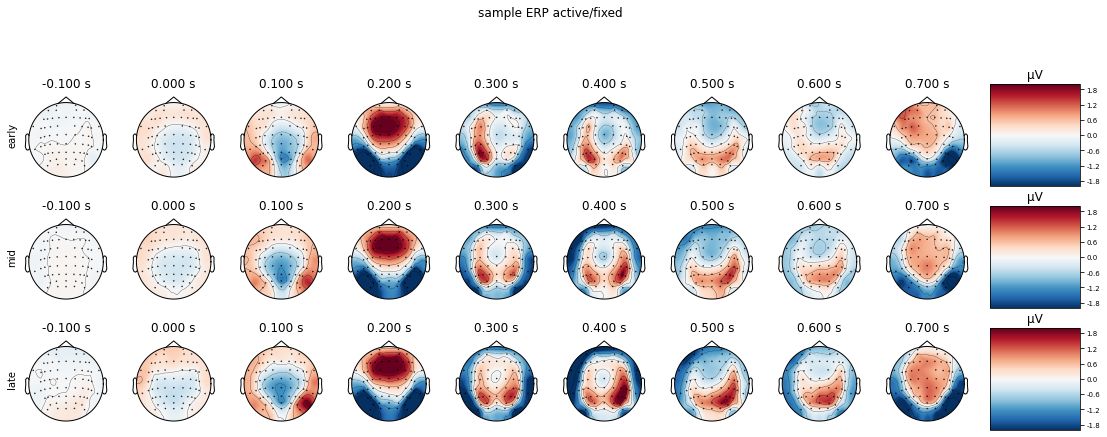

In [24]:
condi = "active/fixed"
fig, axs = plot_topos(split_condi_early_mid_late_erps[condi], vminmax=2)
fig.suptitle("sample ERP {}".format(condi))
display(fig)

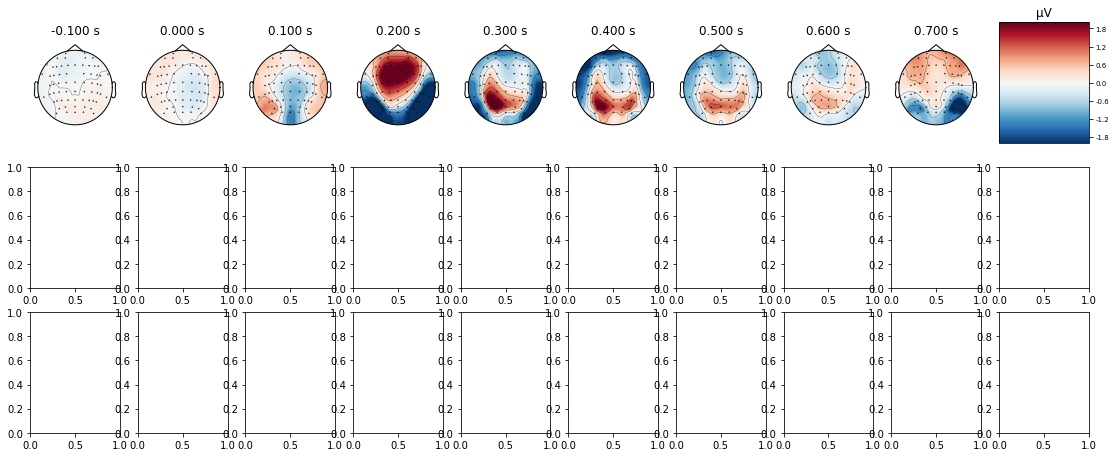

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

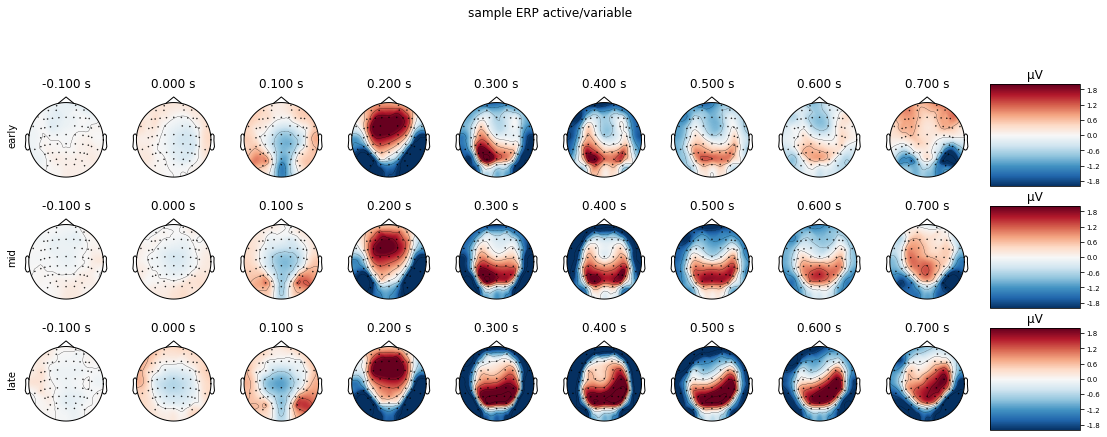

In [25]:
condi = "active/variable"
fig, axs = plot_topos(split_condi_early_mid_late_erps[condi], vminmax=2)
fig.suptitle("sample ERP {}".format(condi))
display(fig)

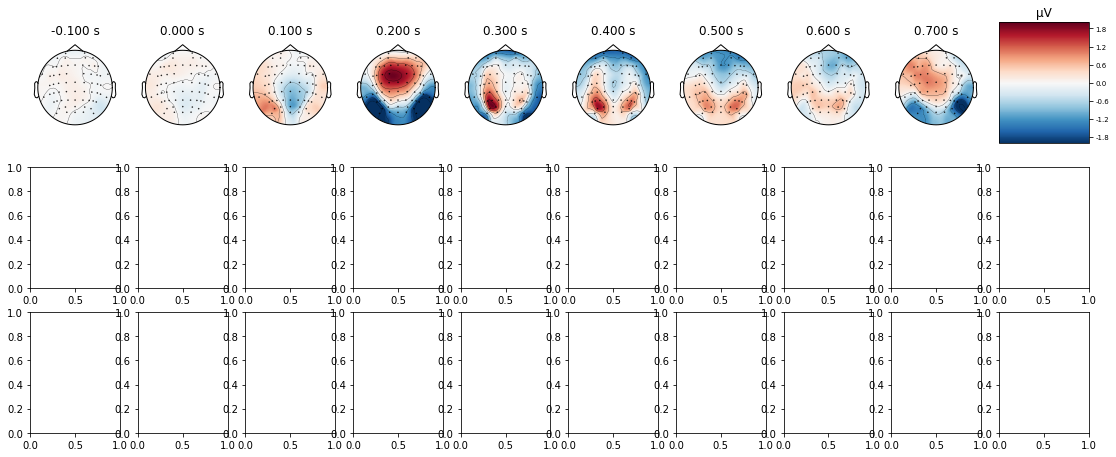

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

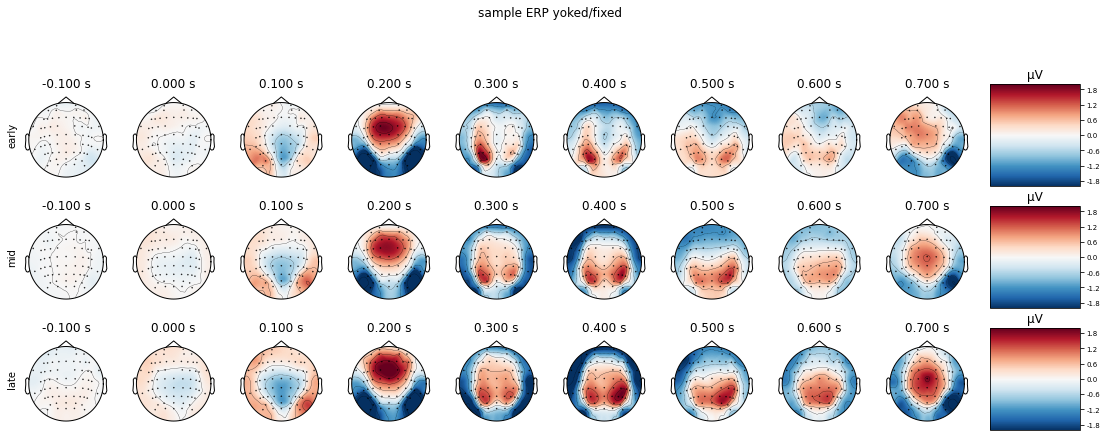

In [26]:
condi = "yoked/fixed"
fig, axs = plot_topos(split_condi_early_mid_late_erps[condi], vminmax=2)
fig.suptitle("sample ERP {}".format(condi))
display(fig)

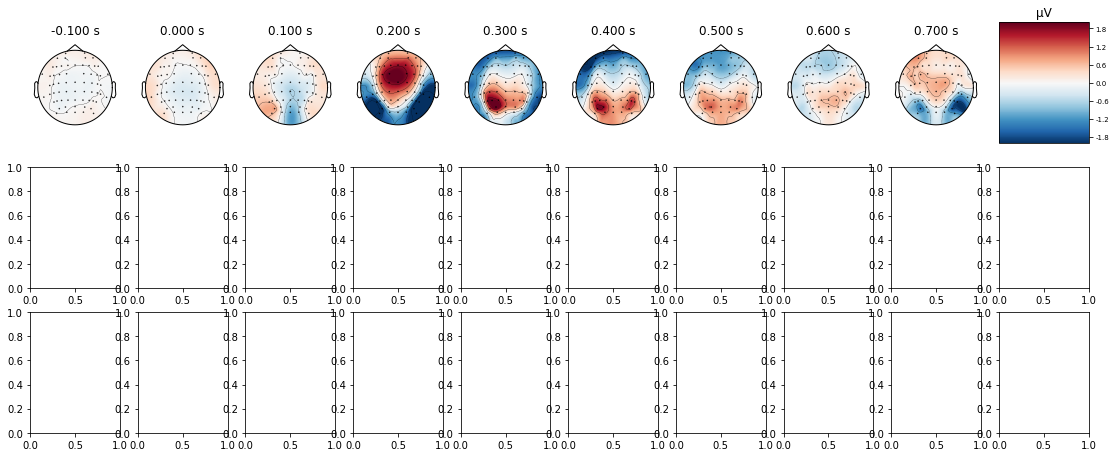

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

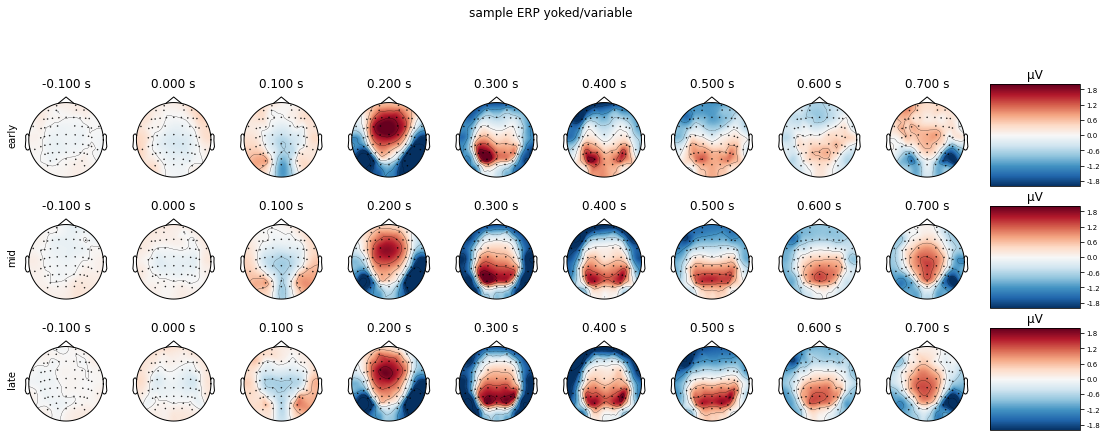

In [27]:
condi = "yoked/variable"
fig, axs = plot_topos(split_condi_early_mid_late_erps[condi], vminmax=2)
fig.suptitle("sample ERP {}".format(condi))
display(fig)

## P3 ERP

In [28]:
cmap = np.array(sns.color_palette("Set1"))[[0, 4, -1], :]
cmap = sns.color_palette(cmap)
cmap = ListedColormap(cmap.as_hex())

**Overview plot**

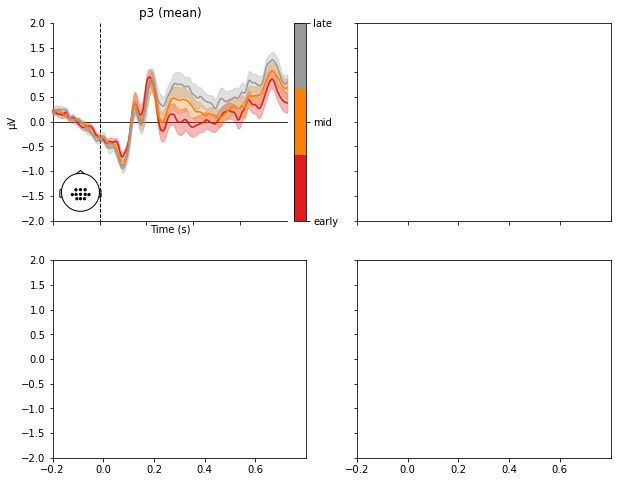

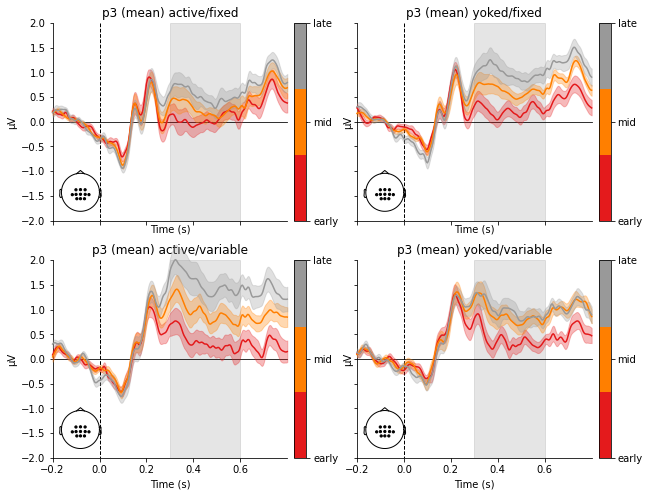

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for i, key in enumerate(
    ["active/fixed", "yoked/fixed", "active/variable", "yoked/variable"]
):

    erp_dict = split_condi_early_mid_late_erps[key]

    colors = np.linspace(0, 1, len(erp_dict.keys()))

    ax = axs.flat[i]
    fig, ax = plot_single_erp(
        erp_dict, p3_grp, "p3", colors, cmap=cmap, ylim=single_panel_ylim, ax=ax
    )

    ax.axvspan(*p3_window, color="black", alpha=0.1)

    ax.set_title(ax.get_title() + " " + key)

display(fig)

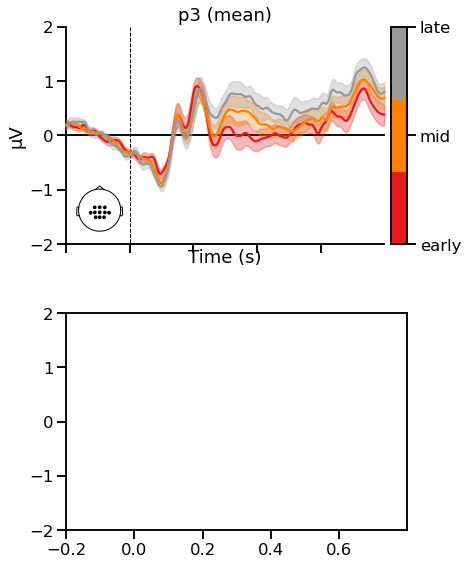

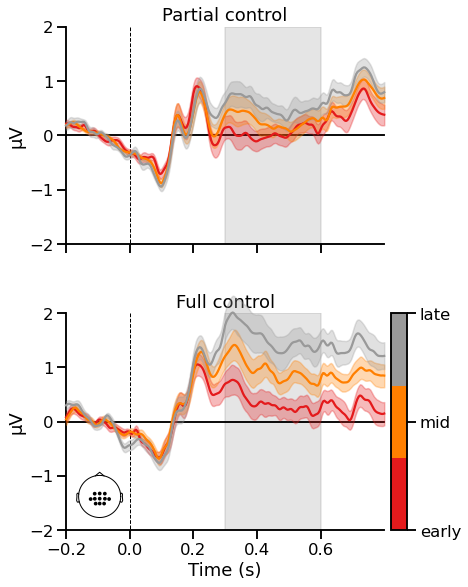

In [30]:
include_yoked_lines_in_plot = False

with sns.plotting_context(context="talk", font_scale=1):

    fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True, sharey=True)
    fig.tight_layout(h_pad=3)

    for i, (key1, key2) in enumerate(
        [("active/fixed", "yoked/fixed"), ("active/variable", "yoked/variable")]
    ):

        erp_dict = split_condi_early_mid_late_erps[key1]
        erp_dict2 = split_condi_early_mid_late_erps[key2]

        colors = np.linspace(0, 1, len(erp_dict.keys()))

        ax = axs.flat[i]
        fig, ax = plot_single_erp(
            erp_dict, p3_grp, "p3", colors, cmap=cmap, ylim=single_panel_ylim, ax=ax
        )

        # optionally plot the yoked lines as well
        if include_yoked_lines_in_plot:
            fig, ax = plot_single_erp(
                erp_dict2,
                p3_grp,
                "p3",
                colors,
                cmap=cmap,
                ylim=single_panel_ylim,
                ax=ax,
                linestyles=dict(zip(erp_dict2.keys(), ("--", "--", "--"))),
            )

        ax.axvspan(*p3_window, color="black", alpha=0.1)

        ax.set_title({0: "Partial control", 1: "Full control"}[i])
        if i == 0:
            ax.set_xlabel("")


# remove duplicate legends
objs = fig.get_children()
# objs[0].remove()  # cannot remove
# objs[1].remove()  # upper axes
# objs[2].remove()  # lower axes
objs[3].remove()  # upper montage plot
objs[4].remove()  # upper cbar
# objs[5].remove()  # lower montage plot
# objs[6].remove()  # lower cbar

display(fig)

Get the **MEANS** from the conditions (given a window)

In [31]:
# Extract p3 means into dataframe format
p3conditiming_df = arr2df(
    condi_early_mid_late_arr,
    p3_grp,
    p3_window,
    condi_early_mid_late_erps.keys(),
    ch_names,
    times,
)

# rename key
p3conditiming_df = p3conditiming_df.rename(columns={"key": "sampling-stopping-timing"})
p3conditiming_df["sampling-stopping-timing"]

# split up colnames
tmp = pd.DataFrame(
    [ii.split("/") for ii in p3conditiming_df["sampling-stopping-timing"]]
)
tmp.columns = ["sampling", "stopping", "timing"]
p3conditiming_df = pd.concat([p3conditiming_df, tmp], axis=1)

# Need to fix subj_repr to be different between stopping fixed and variable
vals = p3conditiming_df.loc[p3conditiming_df["stopping"] == "fixed"][
    "subj_repr"
].to_numpy()
p3conditiming_df.loc[p3conditiming_df["stopping"] == "fixed", "subj_repr"] = vals + 20

# Turn subj_repr into subject column
_all_subjs = []
for _cond in p3conditiming_df["sampling-stopping-timing"].unique():
    # get current data to work on
    _curdat = p3conditiming_df[p3conditiming_df["sampling-stopping-timing"] == _cond]

    # turn subj reprs into idx 0 to 19, assert everything is ordered
    _subj_reprs = _curdat["subj_repr"].to_numpy()
    _subj_reprs2, idx = np.unique(_subj_reprs, return_index=True)
    np.testing.assert_array_equal(_subj_reprs, _subj_reprs2)

    # according to the study setup, "fixed" participants were sub 1, 3, 5, ...
    # and "variable" participants were sub 2, 4, 6, ...
    if "fixed" in _cond:
        assert "variable" not in _cond
        _subjs = np.arange(1, 40, 2)[idx]
    elif "variable" in _cond:
        assert "fixed" not in _cond
        _subjs = np.arange(2, 41, 2)[idx]
    else:
        raise ValueError(f"Unexpected _cond: '{_cond}'")

    _all_subjs += list(_subjs)


# add subject column to df
if "subject" in p3conditiming_df.columns:
    np.testing.assert_array_equal(p3conditiming_df["subject"], _all_subjs)
else:
    p3conditiming_df.insert(0, "subject", _all_subjs)

# sanity check that the subj_repr to subject mapping is unique
assert p3conditiming_df[["subject", "subj_repr"]].drop_duplicates().shape[0] == 40

p3conditiming_df.head()

,subject,sampling-stopping-timing,subj_repr,mean_amp,sampling,stopping,timing
0,1,active/fixed/early,20,1.262673,active,fixed,early
1,3,active/fixed/early,21,0.249706,active,fixed,early
2,5,active/fixed/early,22,0.176448,active,fixed,early
3,7,active/fixed/early,23,-0.174747,active,fixed,early
4,9,active/fixed/early,24,0.639565,active,fixed,early


Text(0.5, 1.05, "window: (0.3, 0.6)s\n['Cz', 'C1', 'C2', 'CPz', 'CP1', 'CP2', 'CP3', 'CP4', 'Pz', 'P1', 'P2']")

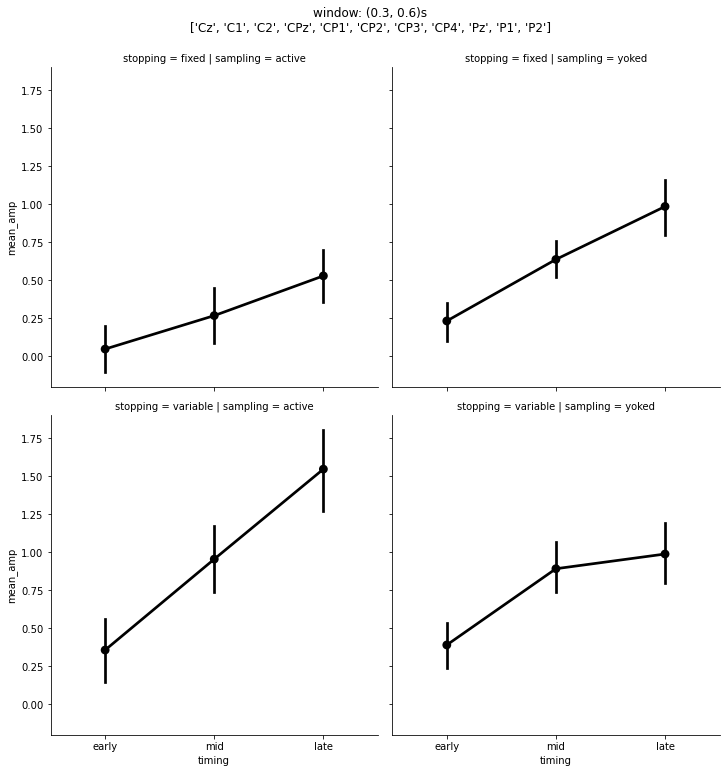

In [32]:
grid = sns.catplot(
    x="timing",
    y="mean_amp",
    data=p3conditiming_df,
    kind="point",
    ci=68,
    col="sampling",
    row="stopping",
    color="black",
)

grid.fig.suptitle("window: {}s\n{}".format(p3_window, p3_grp), y=1.05)

## Early - late "accumulation"  P3 ERP

In [33]:
df_accumul = p3conditiming_df[p3conditiming_df["timing"].isin(["early", "late"])].copy()

# capitalize factor levels
df_accumul.loc[:, "sampling"] = df_accumul["sampling"].str.capitalize().to_list()
df_accumul.loc[:, "stopping"] = df_accumul["stopping"].str.capitalize().to_list()

df_accumul.head()

,subject,sampling-stopping-timing,subj_repr,mean_amp,sampling,stopping,timing
0,1,active/fixed/early,20,1.262673,Active,Fixed,early
1,3,active/fixed/early,21,0.249706,Active,Fixed,early
2,5,active/fixed/early,22,0.176448,Active,Fixed,early
3,7,active/fixed/early,23,-0.174747,Active,Fixed,early
4,9,active/fixed/early,24,0.639565,Active,Fixed,early


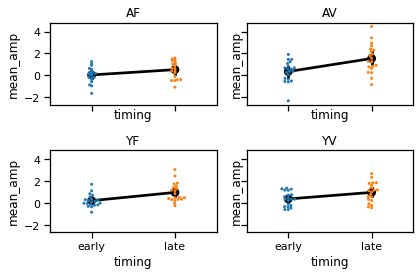

In [34]:
with sns.plotting_context("notebook", font_scale=1):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

    # one plot per task
    for i, (meta, grp) in enumerate(df_accumul.groupby(["sampling", "stopping"])):
        ax = axs.flat[i]

        task = meta[0][0] + meta[1][0]

        sns.pointplot(x="timing", y="mean_amp", data=grp, ax=ax, color="black")
        sns.swarmplot(x="timing", y="mean_amp", data=grp, ax=ax, size=3)

        ax.set_title(task)

    fig.tight_layout()


In [35]:
# compute difference first - second
first = "late"
second = "early"
a = df_accumul[df_accumul["timing"] == first][
    ["subject", "sampling", "stopping"]
].reset_index(drop=True)
b = df_accumul[df_accumul["timing"] == second][
    ["subject", "sampling", "stopping"]
].reset_index(drop=True)
pd.testing.assert_frame_equal(a, b)

mean_amp_diff = (
    df_accumul[df_accumul["timing"] == first]["mean_amp"].to_numpy()
    - df_accumul[df_accumul["timing"] == second]["mean_amp"].to_numpy()
)

colname = f"mean_amp_diff_{first}_minus_{second}"
a[colname] = mean_amp_diff
df_accumul = a.copy()

In [36]:
fname = "eeg_accumulation.csv"
fname = op.join(plotdir, fname)

df_accumul.to_csv(fname, index=False)

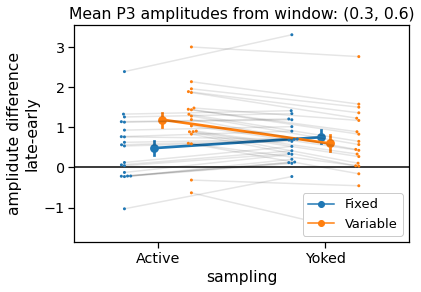

In [37]:
with sns.plotting_context("notebook", font_scale=1.3):
    fig, ax = plt.subplots()

    sns.pointplot(
        x="sampling",
        y=colname,
        hue="stopping",
        data=df_accumul,
        dodge=True,
        ci=68,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        markers="o",
    )

    sns.swarmplot(
        x="sampling",
        y=colname,
        hue="stopping",
        data=df_accumul,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        dodge=True,
        size=3,
    )

    # add legend
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    legend_elements = [
        Line2D([0], [0], color=sns.color_palette()[0], marker="o", label="Fixed"),
        Line2D([0], [0], color=sns.color_palette()[1], marker="o", label="Variable"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower right",
        prop={"size": 13},
        framealpha=1,
    )

    ax.set_ylabel(f"amplidute difference\n{first}-{second}")

    # https://stackoverflow.com/a/51157346/5201771
    # 2-4 3-5
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, color="black", alpha=0.1)

    ax.axhline(0, color="black")
    ax.set_title(f"Mean P3 amplitudes from window: {p3_window}")

**Calc the stats**

anova + posthoc tests

In [38]:
model = pingouin.mixed_anova(
    data=df_accumul,
    dv=colname,
    within="sampling",
    between="stopping",
    subject="subject",
)

model.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,stopping,1.535,1,38,1.535,1.538,0.223,0.039,NaN
1,sampling,0.513,1,38,0.513,1.573,0.217,0.040,1.0
2,Interaction,3.729,1,38,3.729,11.436,0.002,0.231,NaN


In [39]:
stats = pingouin.pairwise_ttests(
    data=df_accumul,
    dv=colname,
    within="sampling",
    between="stopping",
    subject="subject",
    padjust="bonf",
    within_first=False,
    effsize="cohen",
)
display(stats.round(3))

,Contrast,stopping,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,stopping,-,Fixed,Variable,False,True,-1.240,38.0,two-sided,0.223,NaN,NaN,0.566,-0.392
1,sampling,-,Active,Yoked,True,True,1.114,39.0,two-sided,0.272,NaN,NaN,0.303,0.190
2,stopping * sampling,Fixed,Active,Yoked,True,True,-1.940,19.0,two-sided,0.067,0.135,bonf,1.103,-0.356
3,stopping * sampling,Variable,Active,Yoked,True,True,2.772,19.0,two-sided,0.012,0.024,bonf,4.358,0.687


T-tests for each condition > 0

In [40]:
for meta, grp in df_accumul.groupby(["sampling", "stopping"]):
    stats = pingouin.ttest(grp[colname], y=0)
    print(f"\n{meta}, pval = {stats['p-val'][0] * 4:.3f} (bonf. corrected)")

    display(stats.round(3))


('Active', 'Fixed'), pval = 0.046 (bonf. corrected)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.792,19,two-sided,0.012,"[0.12, 0.84]",0.624,4.523,0.755



('Active', 'Variable'), pval = 0.000 (bonf. corrected)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.524,19,two-sided,0.0,"[0.81, 1.57]",1.459,6564.07,1.0



('Yoked', 'Fixed'), pval = 0.001 (bonf. corrected)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.471,19,two-sided,0.0,"[0.4, 1.11]",1.0,118.474,0.989



('Yoked', 'Variable'), pval = 0.033 (bonf. corrected)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.954,19,two-sided,0.008,"[0.17, 1.02]",0.661,6.083,0.8


**Correlations with Accuracy and BNT**

In [41]:
# Load behavioral accuracy data
fname_beh_acc = "beh_accs.csv"
accuracy_df = pd.read_csv(fname_beh_acc)

# also load BNT data, as part of the overall behavioral DF
fname_beh_overall = "behavioral_data.csv"
beh_df = pd.read_csv(fname_beh_overall)

# Drop DESC task for now
accuracy_df = accuracy_df[accuracy_df["task"] != "DESC"].reset_index(drop=True)
beh_df = beh_df[beh_df["task"] != "DESC"].reset_index(drop=True)

# get sampling and stopping from task
accuracy_df["sampling"] = accuracy_df["task"].str[0].map({"A": "active", "Y": "yoked"})
accuracy_df["stopping"] = (
    accuracy_df["task"].str[1].map({"F": "fixed", "V": "variable"})
)

beh_df["sampling"] = beh_df["task"].str[0].map({"A": "active", "Y": "yoked"})
beh_df["stopping"] = beh_df["task"].str[1].map({"F": "fixed", "V": "variable"})

# work on "experienced" accuracy
accuracy_type = "experienced"
accuracy_df = accuracy_df[accuracy_df["accuracy_type"] == accuracy_type]

# work on behavioral df to make it focussed on bnt only
bnt_df = beh_df[["subject", "stopping", "sampling", "bnt_quartile"]].drop_duplicates()

# make a df for doing the correlations
_tmp4corr = df_accumul.copy()
_tmp4corr["sampling"] = _tmp4corr["sampling"].str.lower()
_tmp4corr["stopping"] = _tmp4corr["stopping"].str.lower()
_tmp4corr = _tmp4corr.merge(accuracy_df, on=["subject", "sampling", "stopping"])
_tmp4corr = _tmp4corr.merge(bnt_df, on=["subject", "sampling", "stopping"])

print("------------\nBNT\n")
# Correlate CPP and BNT
for this_task in _tmp4corr["task"].unique():

    print(this_task)
    _curdat = _tmp4corr[_tmp4corr["task"] == this_task]
    stat = pingouin.correlation.corr(
        _curdat[colname], _curdat["bnt_quartile"], method="kendall", tail="two-sided"
    )
    display(stat)

print("------------\nACCURACY\n")
# correlate CPP and accuracy
for this_task in _tmp4corr["task"].unique():

    print(this_task)
    _curdat = _tmp4corr[_tmp4corr["task"] == this_task]
    stat = pingouin.correlation.corr(
        _curdat[colname], _curdat["correct_choice"], method="pearson", tail="two-sided"
    )
    display(stat)

------------
BNT

AF


,n,r,CI95%,p-val,power
kendall,20,0.141528,"[-0.32, 0.55]",0.426616,0.091459


AV


,n,r,CI95%,p-val,power
kendall,20,-0.113689,"[-0.53, 0.35]",0.519871,0.076162


YF


,n,r,CI95%,p-val,power
kendall,20,0.350744,"[-0.11, 0.69]",0.048815,0.338186


YV


,n,r,CI95%,p-val,power
kendall,20,-0.041885,"[-0.48, 0.41]",0.812583,0.052837


------------
ACCURACY

AF


,n,r,CI95%,p-val,BF10,power
pearson,20,0.004702,"[-0.44, 0.45]",0.984304,0.277,0.049304


AV


,n,r,CI95%,p-val,BF10,power
pearson,20,0.356075,"[-0.1, 0.69]",0.123343,0.841,0.347608


YF


,n,r,CI95%,p-val,BF10,power
pearson,20,0.229745,"[-0.24, 0.61]",0.329852,0.432,0.165861


YV


,n,r,CI95%,p-val,BF10,power
pearson,20,0.041727,"[-0.41, 0.48]",0.861339,0.281,0.05281
